In [1]:
import cudf
import sys
import scanpy as sc
#import scFates as scf
#sys.path.append("../ConceptFates/")
sc.settings.verbosity=3
sc.set_figure_params(dpi=150)

import fastools as ft

In [2]:
import pandas as pd
data_path="../../ML6-7"

In [3]:
adata=ft.read_mtx(f"{data_path}/matrix.mtx").T

In [4]:
adata.obs_names=pd.read_csv(f"{data_path}/barcodes.tsv",header=None)[0].values
adata.var_names=pd.read_csv(f"{data_path}/features.tsv",header=None)[0].values

In [5]:
adata.obs["leiden"]=pd.read_csv(f"{data_path}/clus.csv")["x"].astype(str).values

In [6]:
adata.obsm["X_umap"]=pd.read_csv(f"{data_path}/UMAP.csv",index_col=0).values
adata.obsm["X_pca"]=pd.read_csv(f"{data_path}/PCA.csv",index_col=0).values

In [7]:
adata.obs["batch"]=list(map(lambda n: n.split("_")[0], adata.obs_names))


In [8]:
adata.obs.batch=adata.obs.batch.astype("category")
adata.obs.leiden=adata.obs.leiden.astype("category")

In [9]:
cols=pd.read_csv("../leiden_colors.csv",index_col=0)

In [10]:
sc.pp.log1p(adata)

In [11]:
assignment=pd.Series({"14":"NCC","7":"ME",
 "5":"OR","1":"OF",
 "10":"EE","11":"FB",
 "4":"PS1","2":"PS2","9":"PO",
 "12":"PD","6":"ZL","8":"NSC",
 "3":"ON","13":"B"})

In [12]:
adata.obs.leiden= \
    adata.obs.leiden.cat.rename_categories(
        assignment[adata.obs.leiden.cat.categories].values
    )

In [13]:
adata.uns["leiden_colors"]=cols.loc[adata.obs.leiden.cat.categories]["0"].values

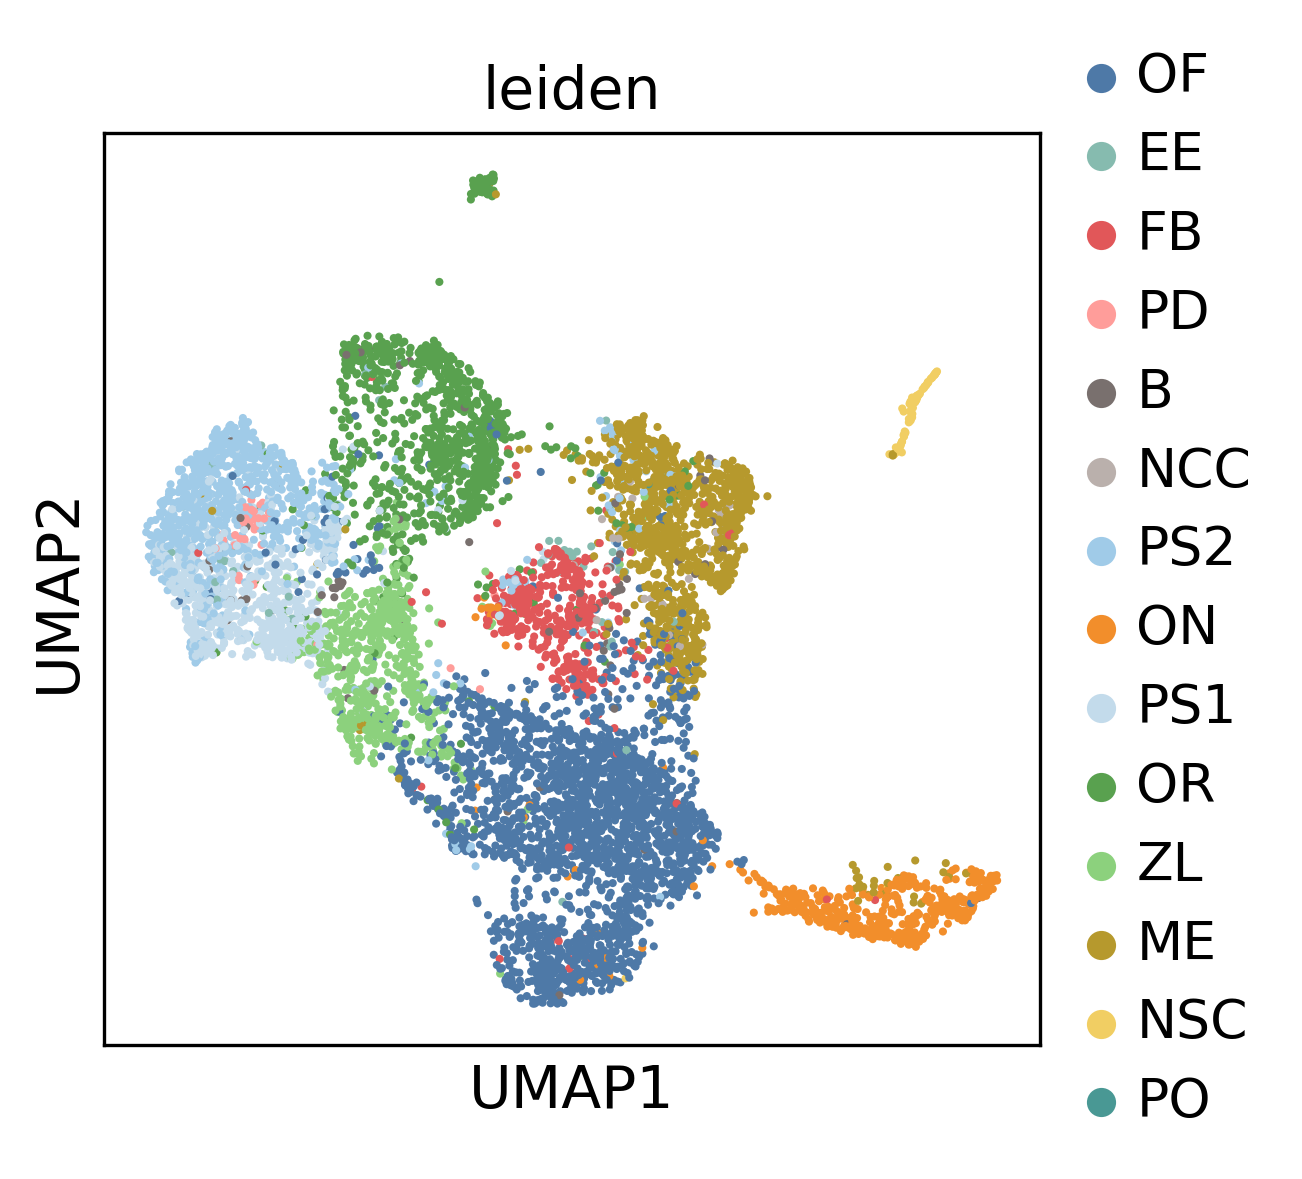

In [14]:
sc.pl.umap(adata,color="leiden")

In [15]:
prop_res = ft.tl.proportion_test(adata,"batch","leiden","ML6","ML7",
                      n_permutations=10000,n_jobs=8)

100%|██████████| 10000/10000 [00:07<00:00, 1323.81it/s]
/data1/soldatr/louis/miniforge3/envs/gpu/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


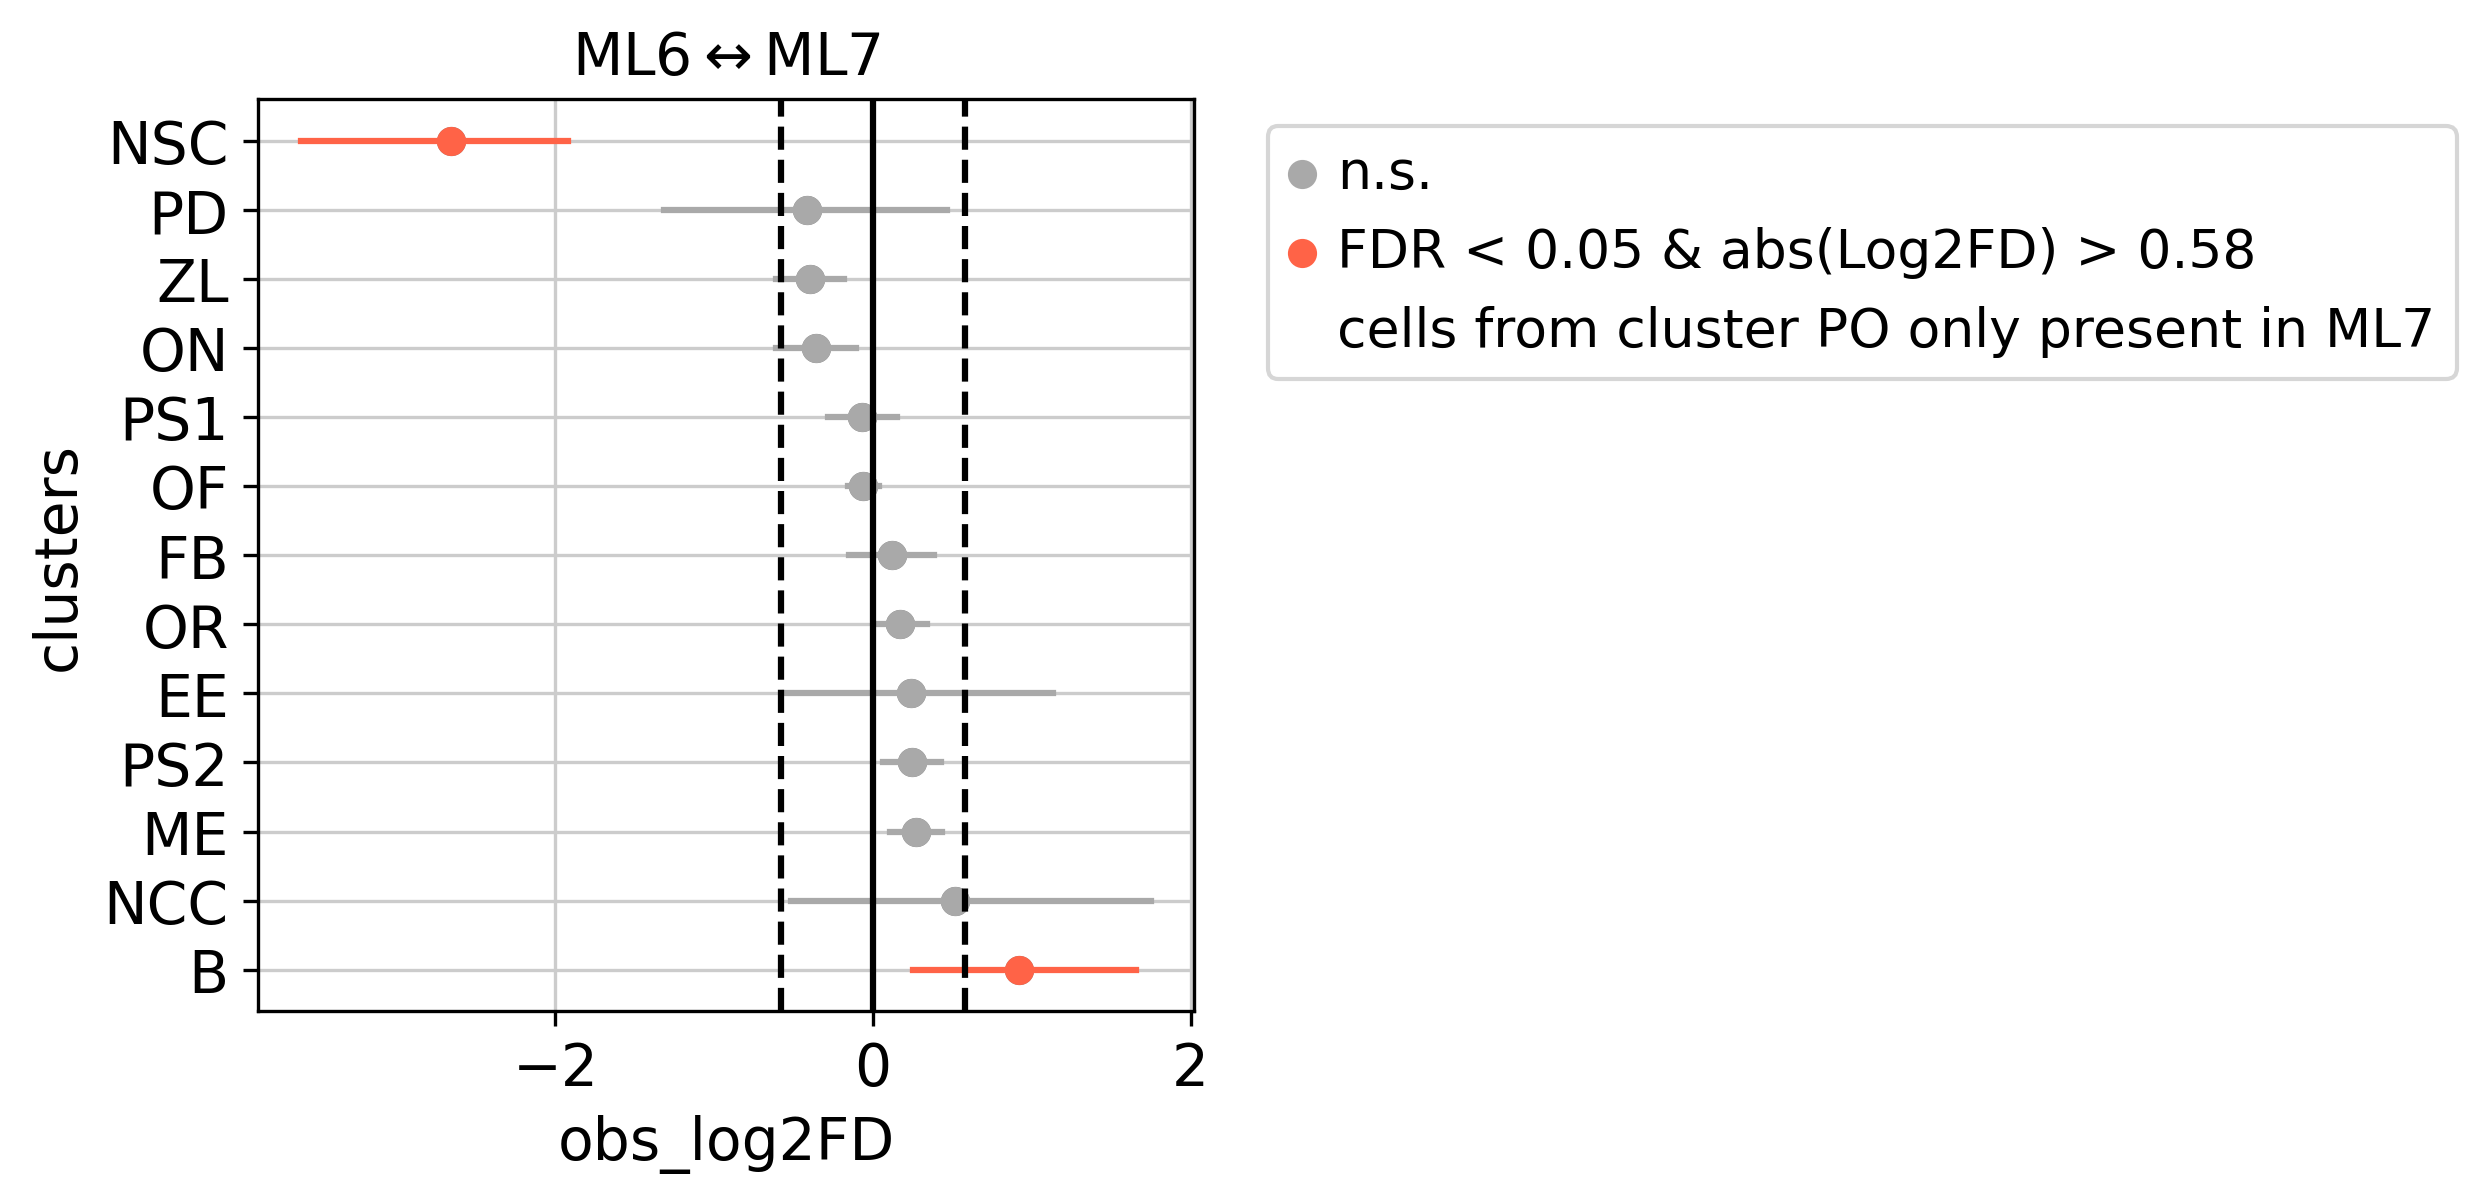

In [16]:
import matplotlib.pyplot as plt
ft.pl.plot_proportion_test(prop_res)

In [17]:
adata_ZL = adata[adata.obs.leiden=="ZL"].copy()
sc.tl.rank_genes_groups(adata_ZL,"batch")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [99]:
res=sc.get.rank_genes_groups_df(adata_ZL,"ML6",pval_cutoff=0.05)

In [92]:
print("\n".join(res.loc[res.logfoldchanges<0].names))

Aldh1a3
Stmn1
Rps21
Larp7
Rpgrip1
Cdkn3
Gad2
Snrpe
Mif
Prc1
Ezh2
Ccnb1
Lig1
Nmt2
Cox6c
Rps15a
Tmsb10
Rpl5
Rpl34
Prelid1
Rpl36
Rps27
Wbp5
Rplp1
Uty
Rps28
Rpl31
Pdlim1
Rec8
Pdap1
Ddx3y
Hspa4l
Hbb-bh1
Serbp1
Tubb5
Nsa2
Rps17
Gm42418
Hmgn1
Rplp2
Rpl38
Tuba1b
Rps8
Rps26
Pbx1
Btg1
Eif3j1
Cbx3
Rps12
Rpl39
Hba-a1
Hba-x
Rpl37
Eif2s2
Hbb-y
Rps29
Rps15
Hnrnpm
Rpl37a
Rpl23a
Rpl6
Rpl41
Rps18-ps3
Gm10260
Rplp0


In [91]:
print("\n".join(res.loc[res.logfoldchanges>0].names))

Xist
Rps2
Gm8730
Tsix
Ubb
Khdrbs3
Fgf9
Rps18
Ubc
Igfbp3
Sulf1
Bambi
mt-Cytb
Ptn
mt-Nd4
mt-Co2
Rgs2
Kdm5c
mt-Co3
mt-Atp6
Kcnq1ot1
Fjx1
Pik3r1
Mmp16
mt-Co1
Gnas
Itga6
Palld
Frs2
Arid5b
mt-Nd2
Kif1b
Col18a1
Ppp1r12b
Crlf1
Eprs
Pnpla3


In [101]:
(res.names=="Cdkn3").sum()

1

Text(0, 0.5, '-log10(p-value)')

/data1/soldatr/louis/miniforge3/envs/gpu/lib/python3.11/site-packages/matplotlib/text.py:1475: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/data1/soldatr/louis/miniforge3/envs/gpu/lib/python3.11/site-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/data1/soldatr/louis/miniforge3/envs/gpu/lib/python3.11/site-packages/matplotlib/text.py:897: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/data1/soldatr/louis/miniforge3/envs/gpu/lib/python3.11/site-packages/matplotlib/text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will 

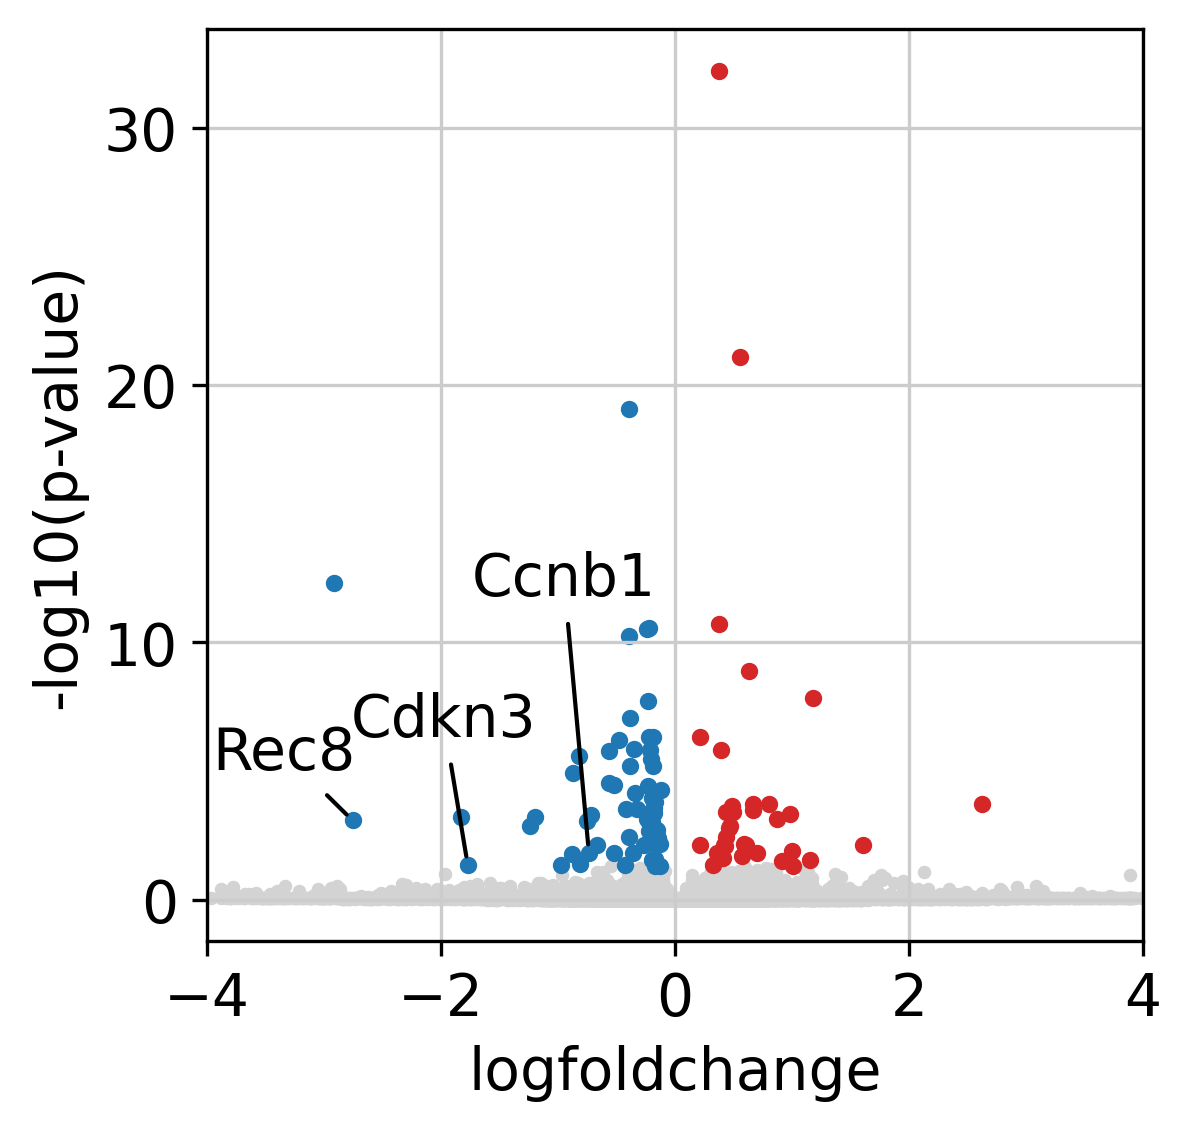

In [125]:
import numpy as np
res=sc.get.rank_genes_groups_df(adata_ZL,"ML6")
plt.scatter(res.iloc[1:,2],-np.log10(res.iloc[1:,4]),s=5,c="lightgrey")
res=sc.get.rank_genes_groups_df(adata_ZL,"ML6",pval_cutoff=0.05,log2fc_min=0)
plt.scatter(res.iloc[1:,2],-np.log10(res.iloc[1:,4]),s=10,c="tab:red")
res=sc.get.rank_genes_groups_df(adata_ZL,"ML6",pval_cutoff=0.05,log2fc_max=0)
plt.scatter(res.iloc[1:,2],-np.log10(res.iloc[1:,4]),s=10,c="tab:blue")
plt.xlim([-4,4])


res=sc.get.rank_genes_groups_df(adata_ZL,"ML6",pval_cutoff=0.05)

plt.annotate("Cdkn3",
   (res.loc[res.names=="Cdkn3","logfoldchanges"],
    -np.log10(res.loc[res.names=="Cdkn3","pvals_adj"])),
    (res.loc[res.names=="Cdkn3","logfoldchanges"]-1,
    -np.log10(res.loc[res.names=="Cdkn3","pvals_adj"])+5), 
             arrowprops=dict(facecolor='black', arrowstyle='-'))

plt.annotate("Ccnb1",
   (res.loc[res.names=="Ccnb1","logfoldchanges"],
    -np.log10(res.loc[res.names=="Ccnb1","pvals_adj"])),
    (res.loc[res.names=="Ccnb1","logfoldchanges"]-1,
    -np.log10(res.loc[res.names=="Ccnb1","pvals_adj"])+10), 
             arrowprops=dict(facecolor='black', arrowstyle='-'))

plt.annotate("Rec8",
   (res.loc[res.names=="Rec8","logfoldchanges"],
    -np.log10(res.loc[res.names=="Rec8","pvals_adj"])),
    (res.loc[res.names=="Rec8","logfoldchanges"]-1.2,
    -np.log10(res.loc[res.names=="Rec8","pvals_adj"])+2), 
             arrowprops=dict(facecolor='black', arrowstyle='-'))

plt.xlabel("logfoldchange")
plt.ylabel("-log10(p-value)")

In [20]:
adata_ZL.obs['stim'] = adata_ZL.obs['batch'].cat.rename_categories(["MUT","WT"])

In [21]:
indices = adata_ZL.obs.sort_values([ 'stim']).index

In [22]:
adata_ZL = adata_ZL[indices,:]

In [23]:
import gseapy as gp

In [24]:
adata_ZL.var_names=adata_ZL.var_names.str.upper()

In [25]:
adata_ZL.var_names_make_unique()

In [65]:
res=sc.get.rank_genes_groups_df(adata_ZL,"ML6")

In [68]:
res = gp.gsea(data=adata_ZL.to_df().T, # row -> genes, column-> samples
        gene_sets="GO_Biological_Process_2021",
        cls=adata_ZL.obs.stim,
        permutation_num=1000,
        permutation_type='phenotype',
        outdir=None,
        method='s2n', # signal_to_noise
        threads= 8)

/data1/soldatr/louis/miniforge3/envs/gpu/lib/python3.11/site-packages/gseapy/gsea.py:110: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_std = df.groupby(by=cls_dict, axis=1).std(numeric_only=True, ddof=0)
/data1/soldatr/louis/miniforge3/envs/gpu/lib/python3.11/site-packages/gseapy/gsea.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_std.abs().sum(axis=1) > 0]


In [77]:
(res.res2d["FDR q-val"]<0.01).sum()

17

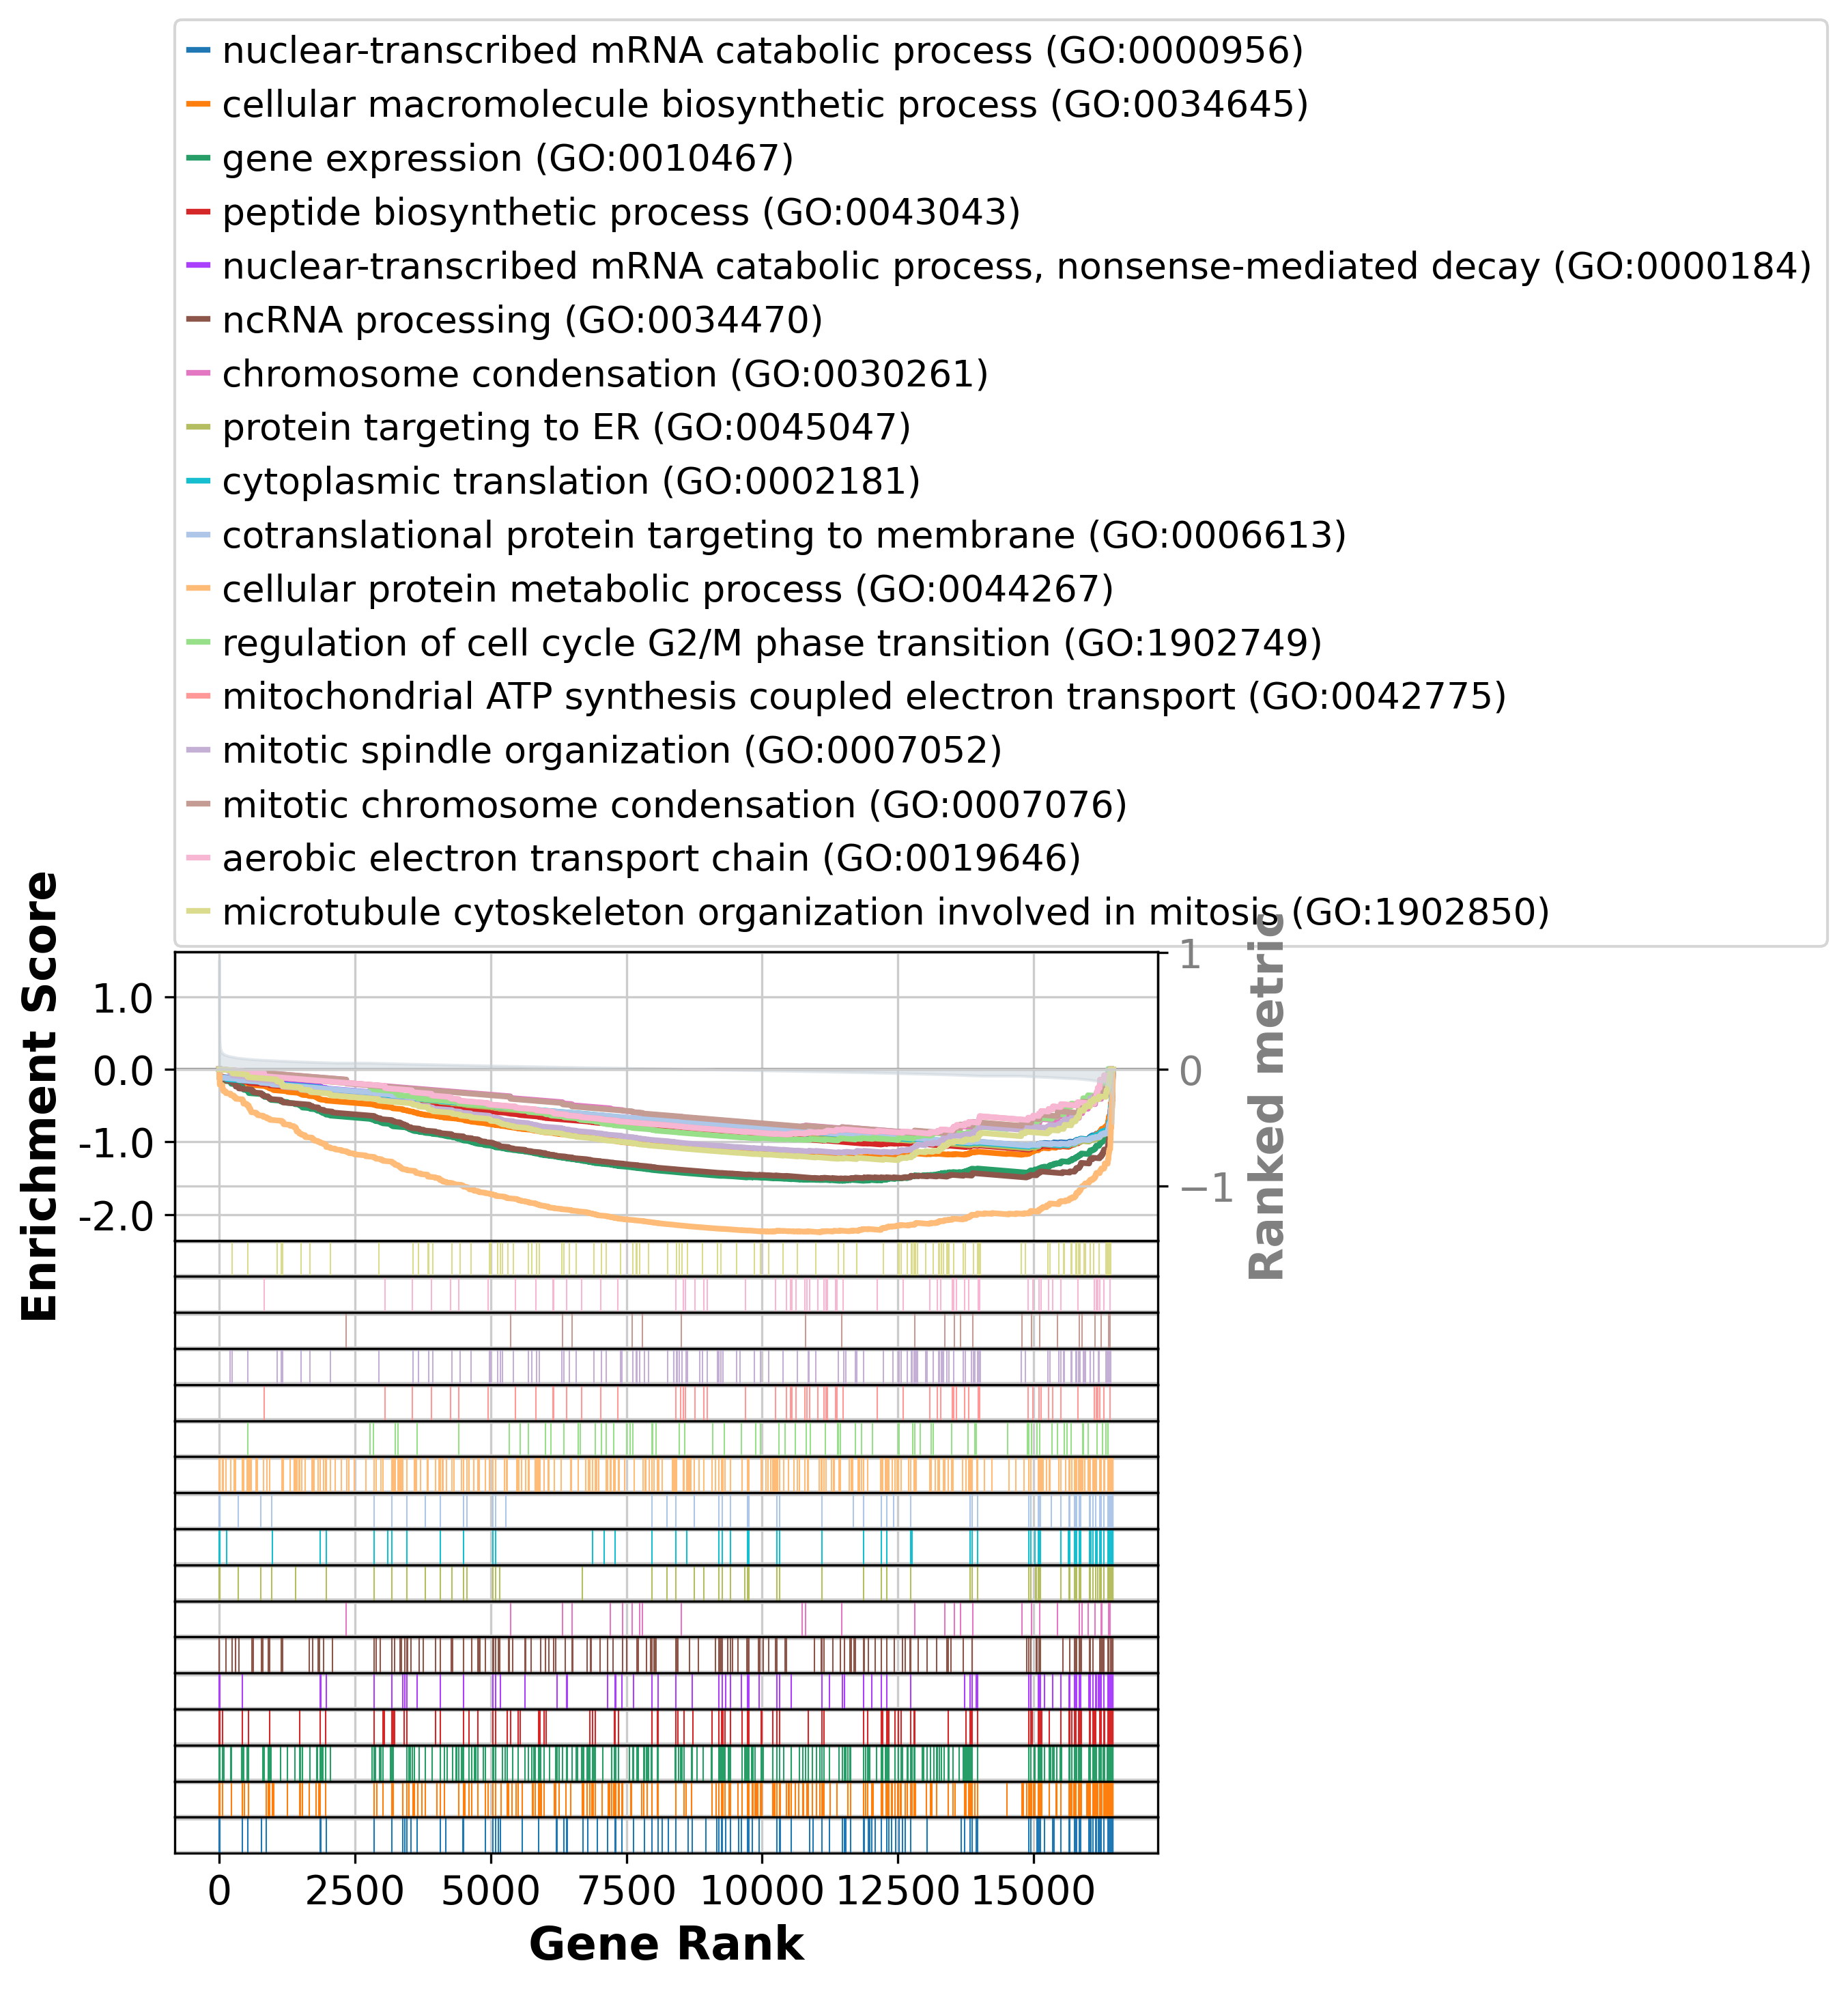

In [79]:
term = res.res2d.Term
term = term[res.res2d["FDR q-val"]<0.01]
# gp.gseaplot(res.ranking, term=term[i], **res.results[term[i]])
axs = res.plot(terms=term)

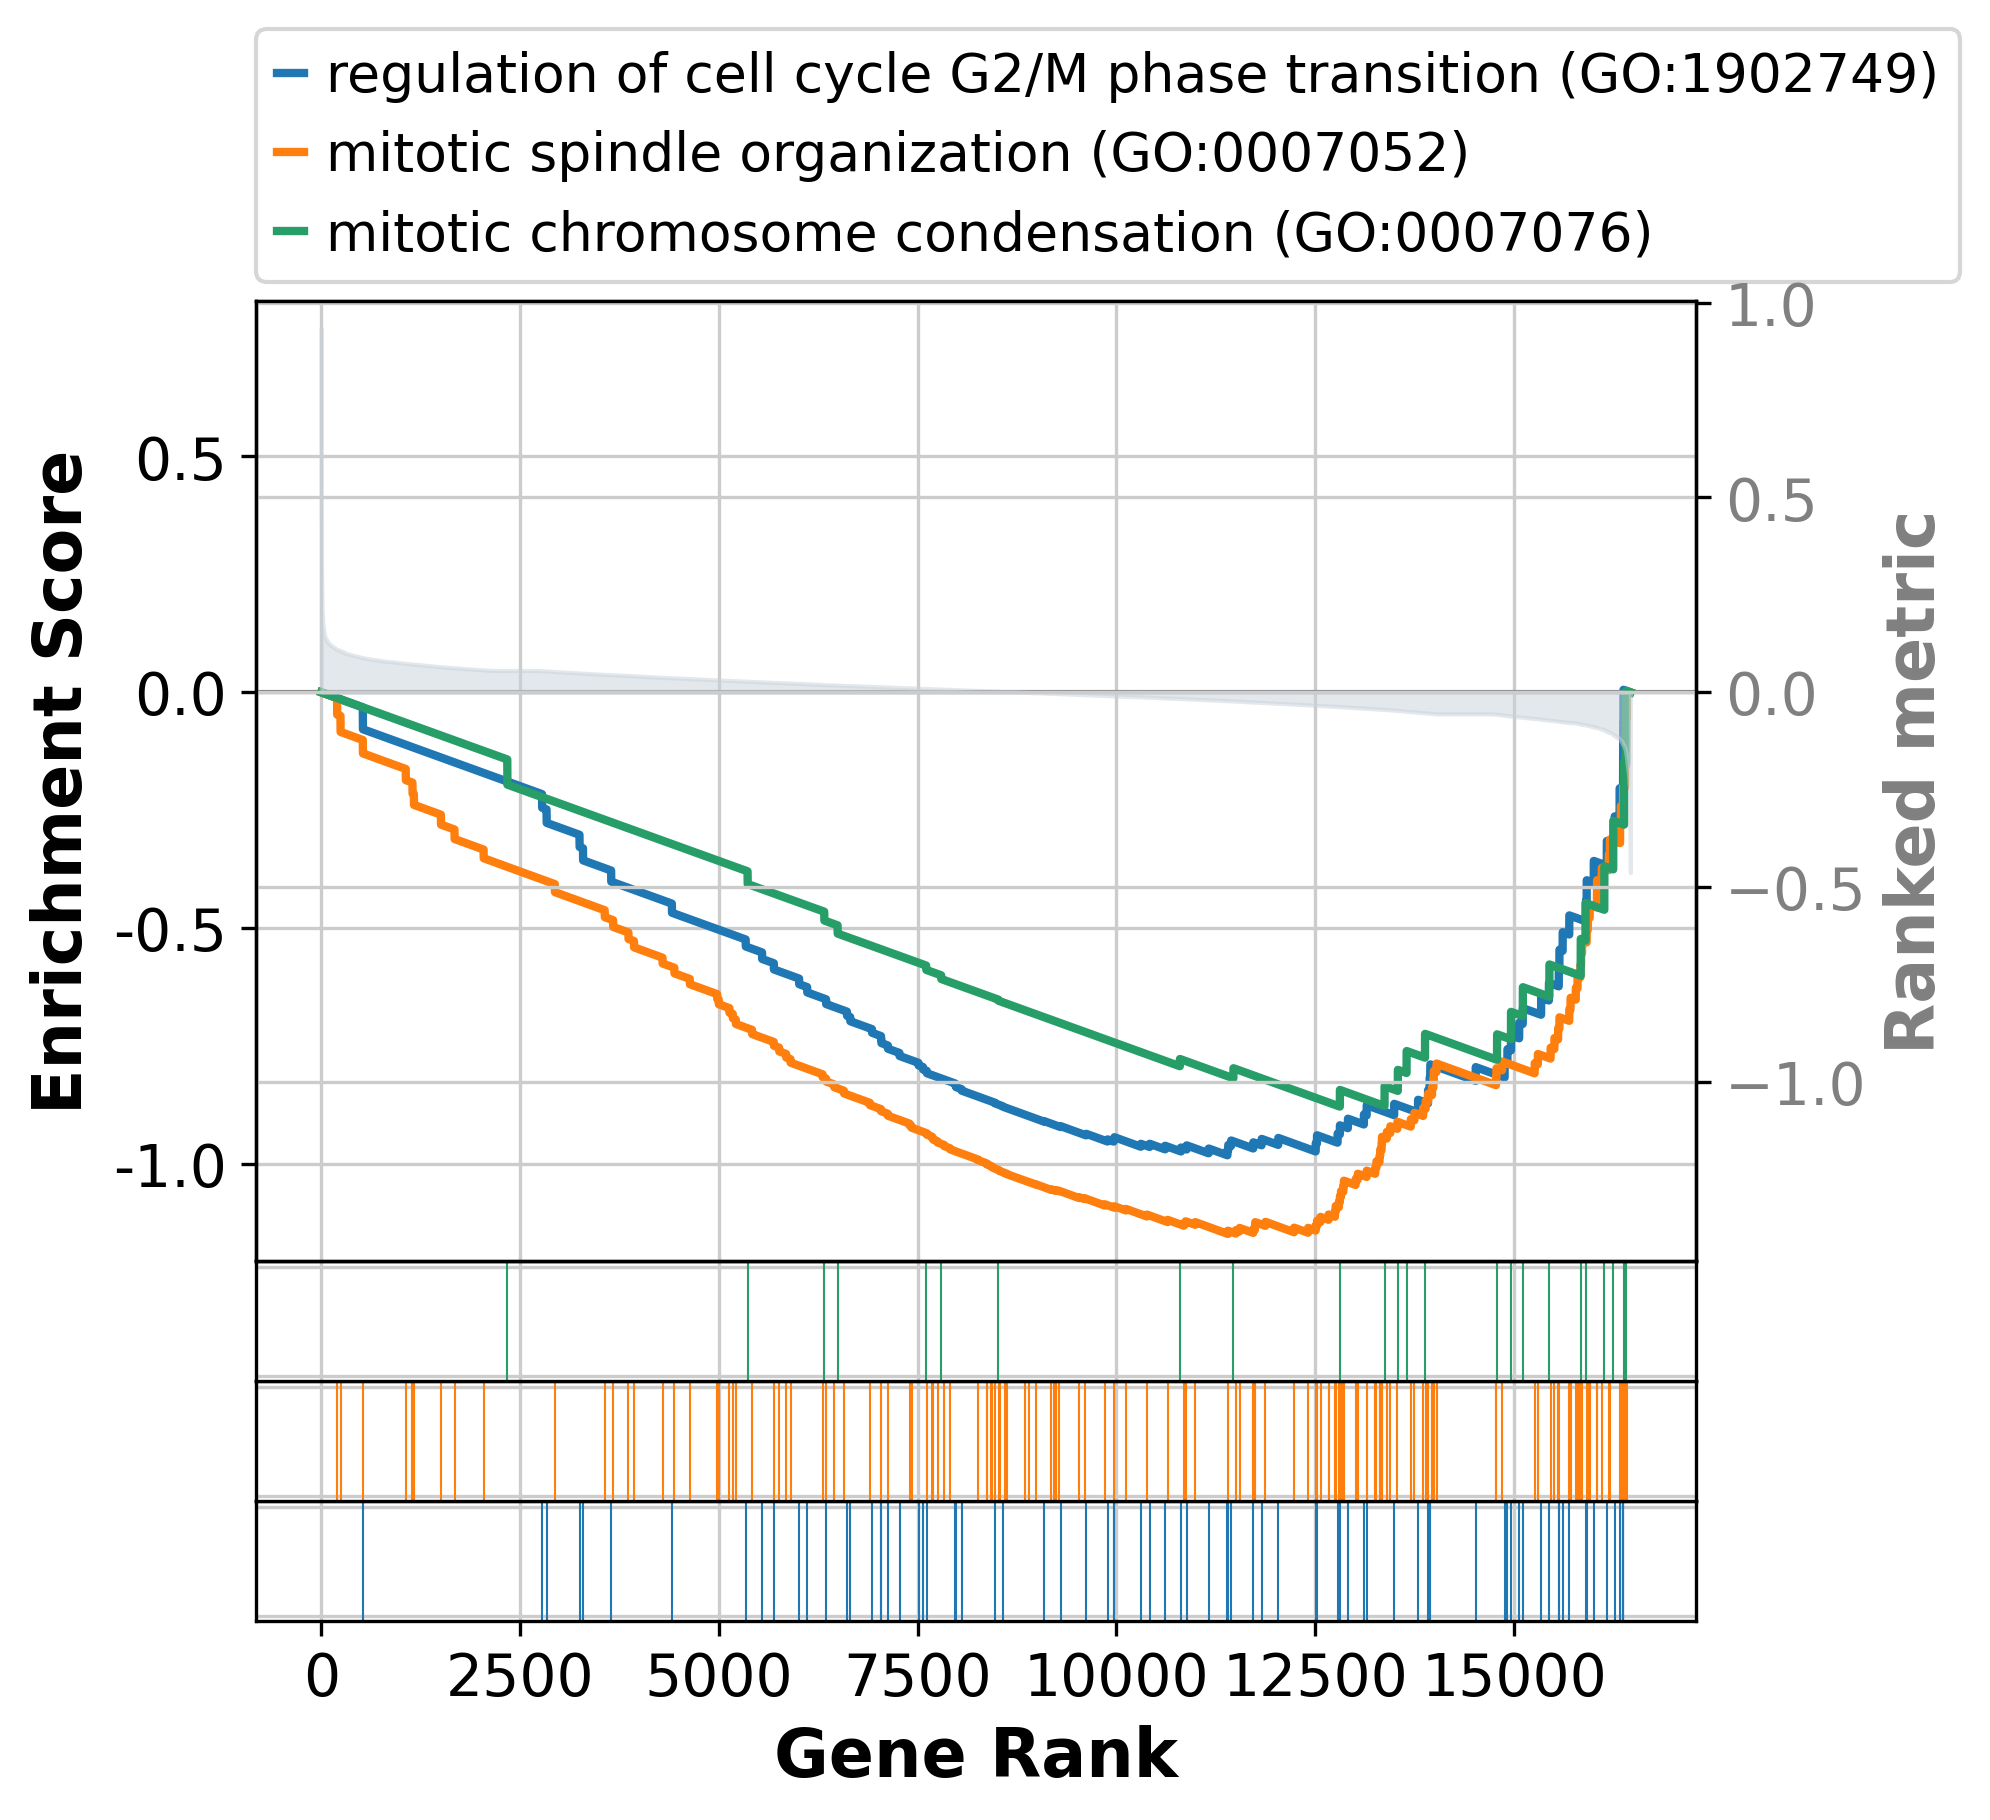

In [84]:
axs = res.plot(terms=term[term.str.contains("cycle") | term.str.contains("mitotic")])

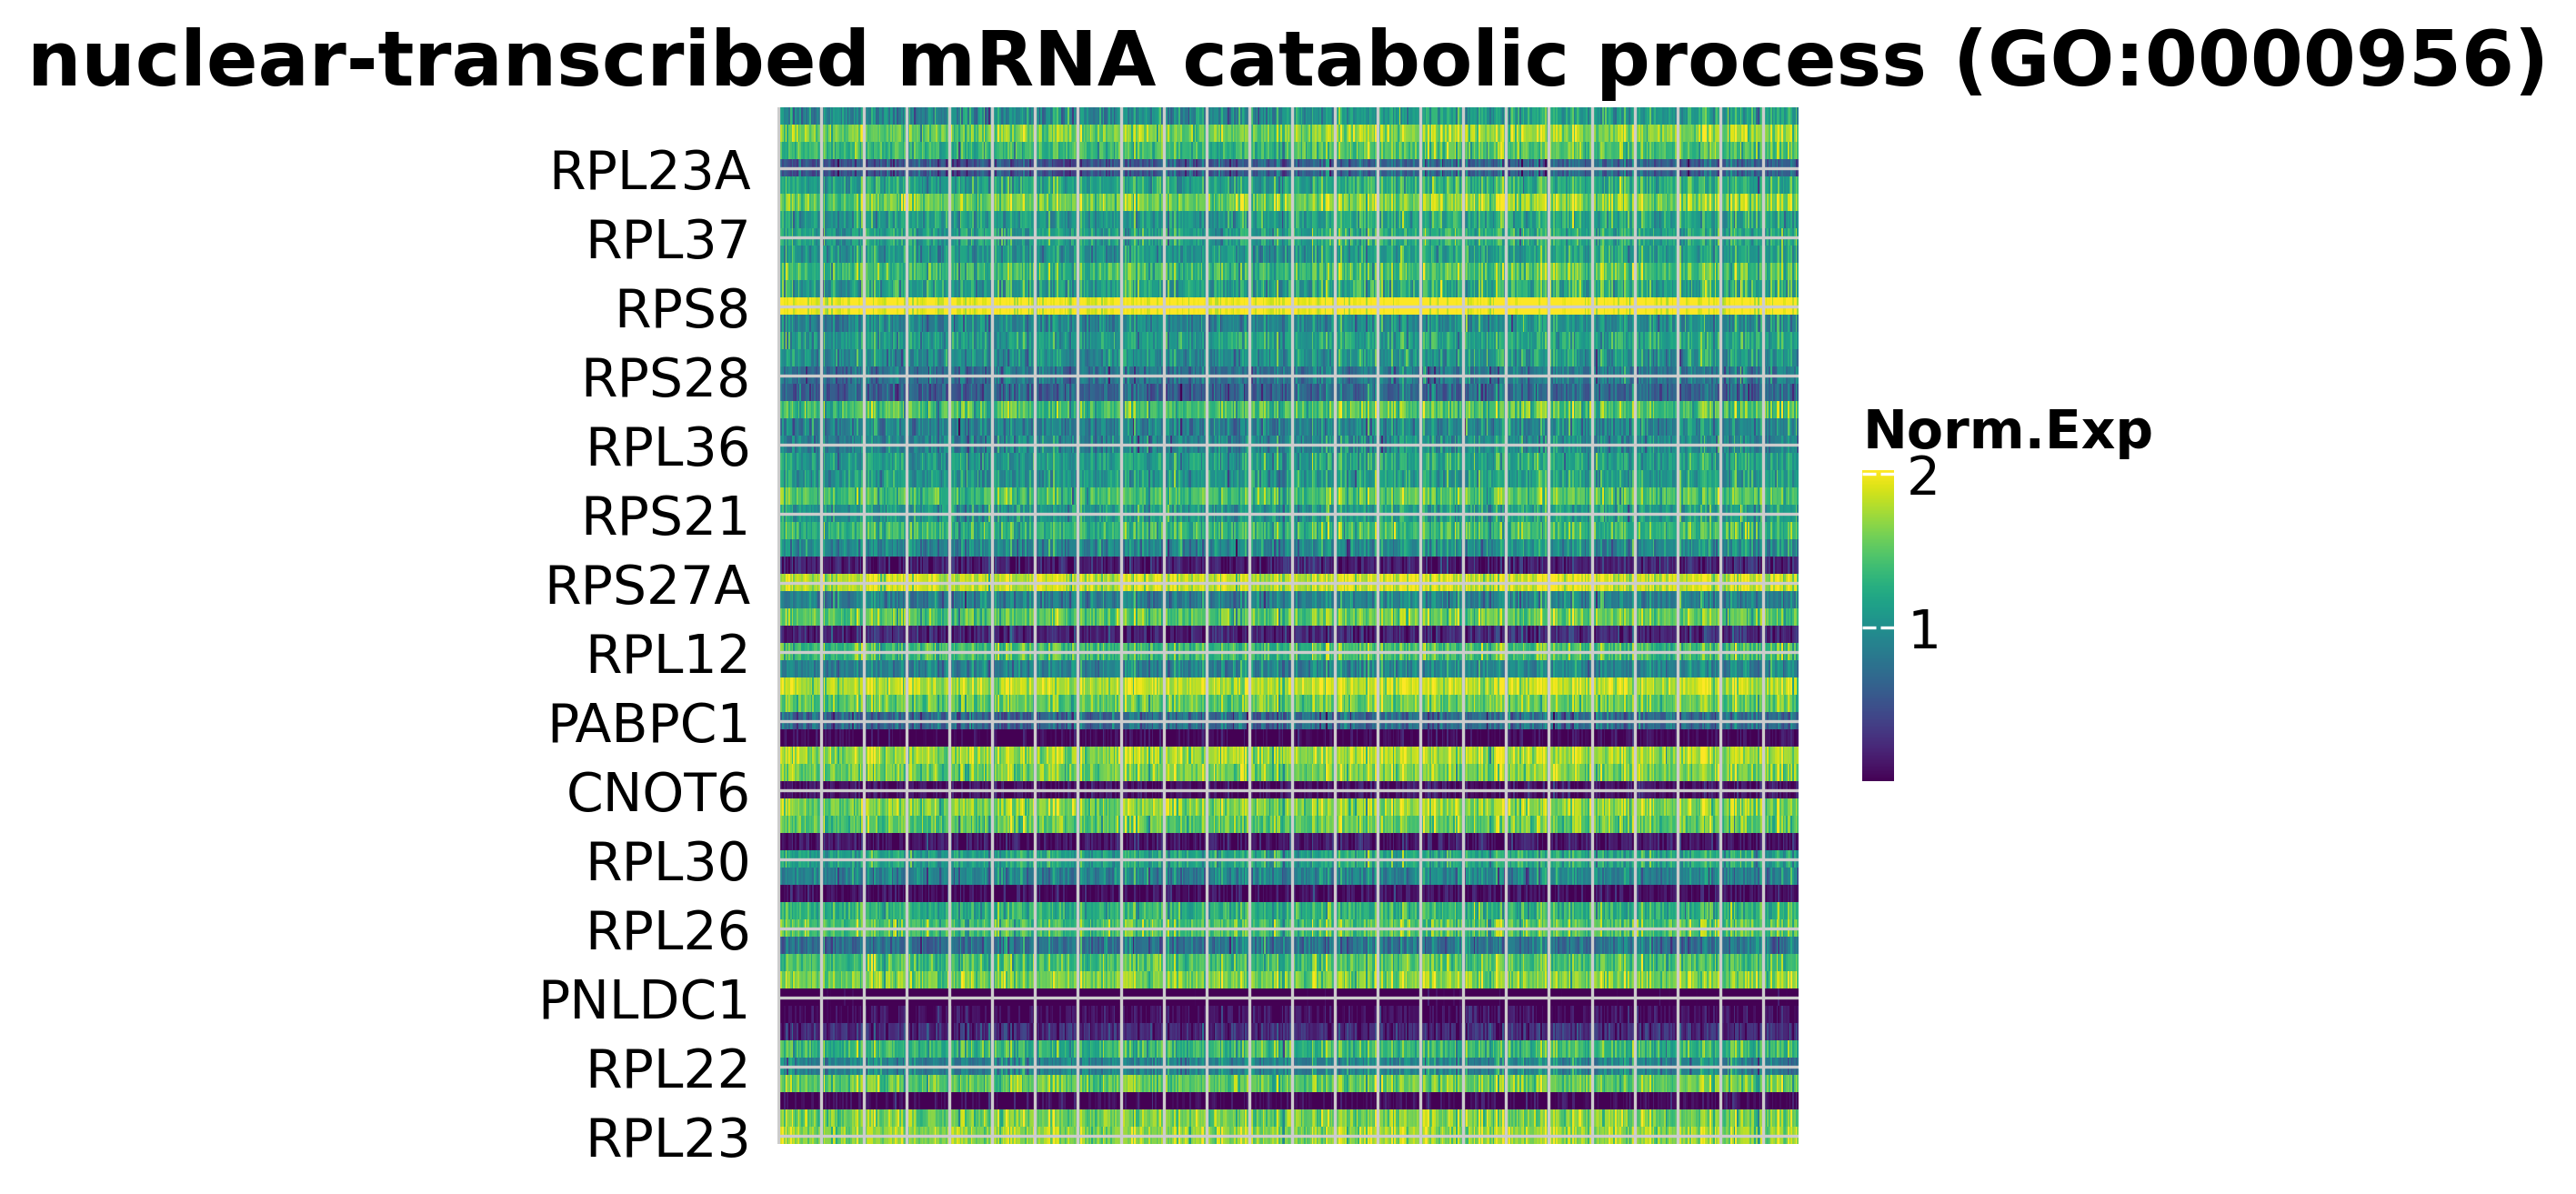

In [31]:
## Heatmap of gene expression
i = 0
genes = res.res2d.Lead_genes.iloc[i].split(";")
ax = gp.heatmap(df = res.heatmat.loc[genes],
           z_score=None,
           title=res.res2d.Term.iloc[i],
           figsize=(6,5),
           cmap=plt.cm.viridis,
           xticklabels=False)

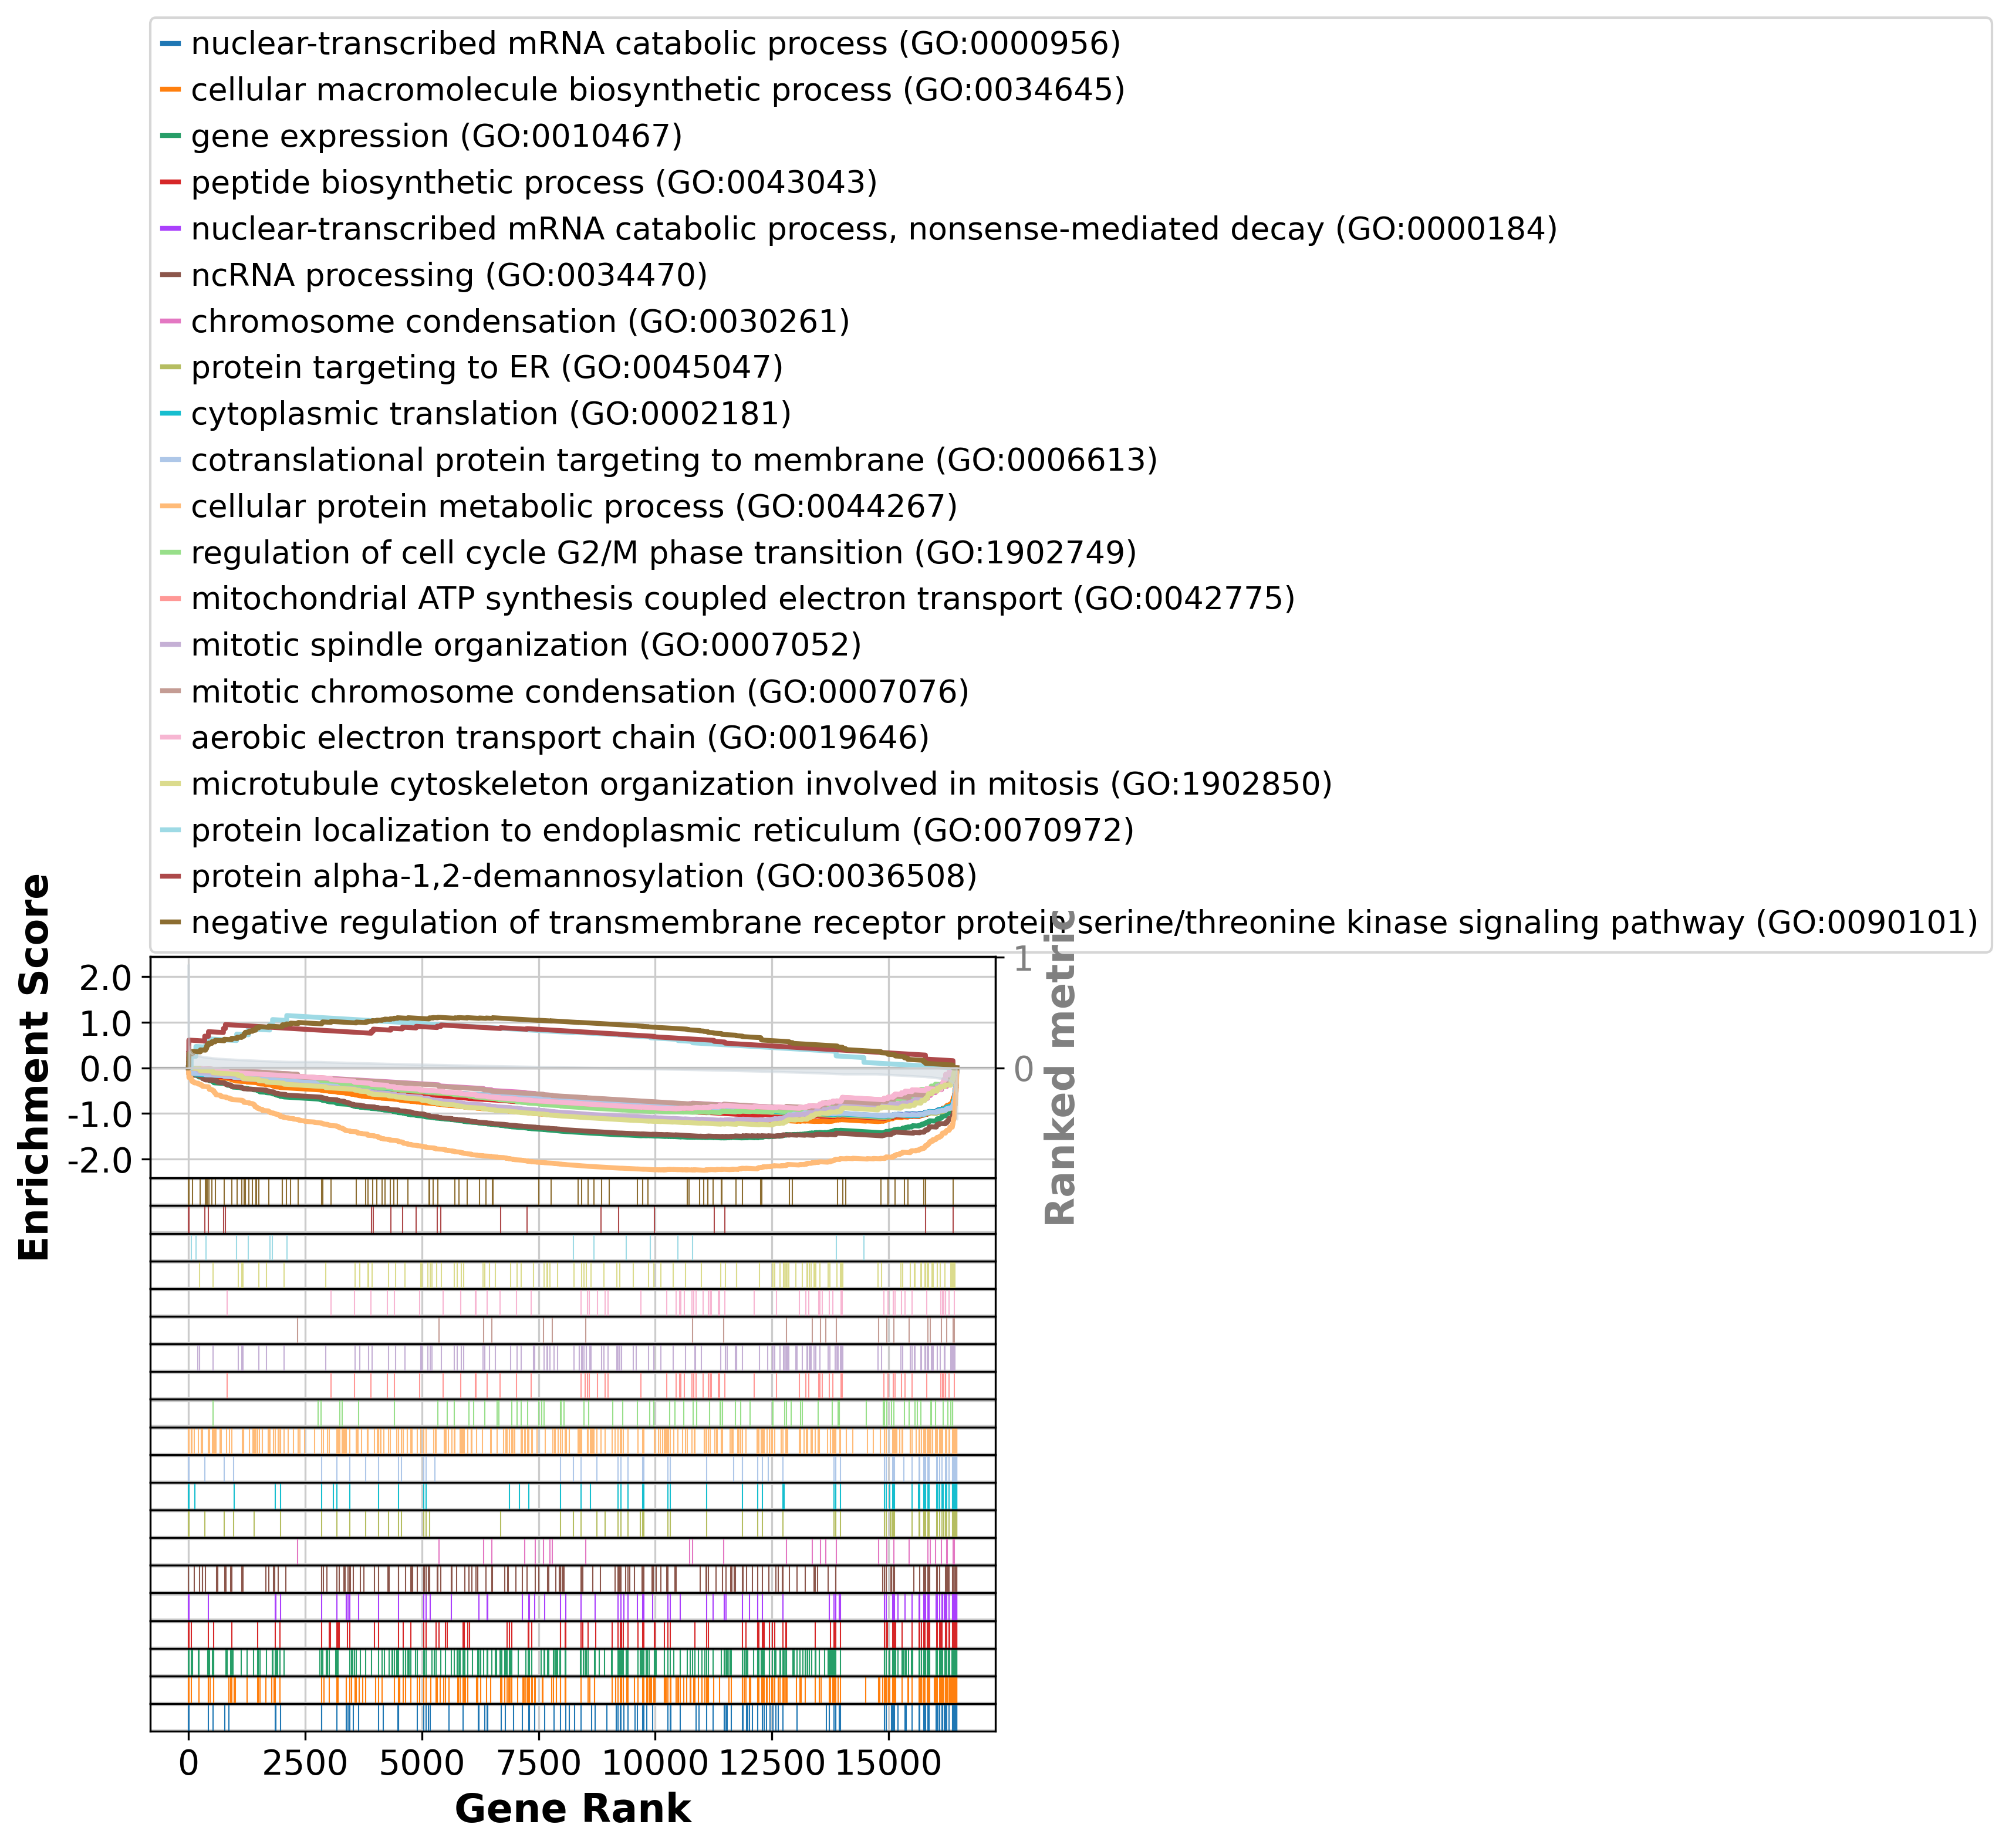

In [28]:
term = res.res2d.Term
# gp.gseaplot(res.ranking, term=term[i], **res.results[term[i]])
axs = res.plot(terms=term[:20])

In [55]:
res.res2d.head(10)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,nuclear-transcribed mRNA catabolic process (GO...,0.6206,2.487637,0.0,0.0,0.0,60/160,9.42%,RPLP0;RPL41;RPL6;RPL23A;RPL37A;RPS29;RPS15;RPL...
1,gsea,cellular macromolecule biosynthetic process (G...,0.502706,2.478577,0.0,0.0,0.0,122/289,25.92%,RPLP0;RPL41;RPL6;RPL23A;RPL37A;RPS29;RPS15;RPL...
2,gsea,gene expression (GO:0010467),0.448061,2.424141,0.0,0.0,0.0,138/332,30.29%,RPLP0;RPL41;RPL6;RPL23A;RPL37A;RPS29;RPS15;RPL...
3,gsea,peptide biosynthetic process (GO:0043043),0.637149,2.341499,0.0,0.000716,0.003,60/144,9.42%,RPLP0;RPL41;RPL6;RPL23A;RPL37A;RPS29;RPS15;RPL...
4,gsea,ncRNA processing (GO:0034470),0.491097,2.316079,0.0,0.000859,0.005,74/188,29.46%,RPLP0;RPL41;RPL6;RPL23A;RPL37A;RPS15;RPL37;RPL...
5,gsea,chromosome condensation (GO:0030261),0.64447,2.250888,0.0,0.002267,0.016,16/30,18.78%,CCNB1;NUSAP1;TOP2A;RB1;NCAPD2;ACIN1;CHMP1A;NCA...
6,gsea,"nuclear-transcribed mRNA catabolic process, no...",0.696782,2.248219,0.002041,0.001944,0.016,56/111,9.42%,RPLP0;RPL41;RPL6;RPL23A;RPL37A;RPS29;RPS15;RPL...
7,gsea,regulation of cell cycle G2/M phase transition...,0.468123,2.237966,0.0,0.002238,0.02,39/79,30.78%,NPM1;TUBA1A;DYNC1I2;HMMR;CEP76;PLK4;KIF14;TPX2...
8,gsea,mitotic spindle organization (GO:0007052),0.453756,2.232544,0.002114,0.002148,0.022,72/141,30.75%,RPS27;CCNB1;PRC1;STMN1;DYNC1I2;SPC25;CENPA;NUP...
9,gsea,mitotic chromosome condensation (GO:0007076),0.649213,2.187544,0.0,0.00358,0.043,15/24,22.19%,CCNB1;NUSAP1;RB1;NCAPD2;CHMP1A;NCAPG;CSNK2B;SM...


In [44]:
prop_res.to_csv("results/perm_test_res_ML6-7.csv")

In [45]:
res=pd.DataFrame(0,index=adata.obs.batch.cat.categories,columns=adata.obs.leiden.cat.categories)
res=pd.concat(list(map(lambda b: (adata.obs.loc[adata.obs.batch==b,"leiden"].value_counts()/(adata.obs.batch==b).sum())*100,
         adata.obs.batch.cat.categories)),axis=1)
res.columns=adata.obs.batch.cat.categories

totals=pd.DataFrame(list(map(lambda b: (adata.obs.batch==b).sum(),res.columns)),
            columns=["total"],index=res.columns).T

res.index = res.index.astype(str)

res = pd.concat([res,pd.DataFrame(list(map(lambda b: (adata.obs.batch==b).sum(),res.columns)),
            columns=["total"],index=res.columns).T],axis=0)
res.loc["total"]=res.loc["total"].astype(int)

In [46]:
res.to_csv("results/prop_totals_ML6-7.csv")